# Dermascopic images blur analysis
To estimate the blur we will use the simplest approach - laplacian operator, which normally determines edges in an image. By looking at the variance of of the result we can estimate the detalization of the image. However in the case of skin images it might me quite challenging, especially with low resolution images..

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from IPython.display import display_html
from PIL import Image
import gc
import cv2

# list(os.listdir('../input/siim-isic-melanoma-classification'))

In [16]:
# Directory
directory = '../input/siim-isic-melanoma-classification'
IMAGE_PATH = "../input/siim-isic-melanoma-classification/"

# Import the 2 csv s
train_df = pd.read_csv(directory + '/train.csv')
test_df = pd.read_csv(directory + '/test.csv')

print('Train has {:,} rows and Test has {:,} rows.'.format(len(train_df), len(test_df)))

img_dir = IMAGE_PATH+'/jpeg/train'

Train has 33,126 rows and Test has 10,982 rows.


In [13]:
# to work with DICOM files
def show_images(data, n = 5, rows=1, cols=5, title='Default'):
    plt.figure(figsize=(16,4))

    for k, path in enumerate(data['path_dicom'][:n]):
        image = pydicom.read_file(path)
        image = image.pixel_array
        
        # image = resize(image, (200, 200), anti_aliasing=True)

        plt.suptitle(title, fontsize = 16)
        plt.subplot(rows, cols, k+1)
        plt.imshow(image)
        plt.axis('off')

In [4]:
benign = train_df[train_df['benign_malignant']=='benign']
malignant = train_df[train_df['benign_malignant']=='malignant']

In [5]:
random9_mal = [np.random.choice(malignant['image_name'].values+'.jpg') for i in range(9)]
random9_ben = [np.random.choice(benign['image_name'].values+'.jpg') for i in range(9)]

In [6]:
def variance_of_laplacian(image):
# compute the Laplacian of the image and then return the focus
# measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

def laplacian(image):
# compute the Laplacian of the image and then return the focus
# measure, which is simply the variance of the Laplacian
    res = cv2.Laplacian(image, cv2.CV_64F)
    lap_var = res.var()
    return res, lap_var

In [7]:
# show 9 images with Blur Index in 3*3 grid
def show9(images, l_type):
    print(f'Display {l_type} Images')

    # Adjust the size of your images
    plt.figure(figsize=(10,8))

    # Iterate and plot random images
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        img = plt.imread(os.path.join(img_dir, images[i]))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        fm = variance_of_laplacian(gray)
        plt.title(f'Bluriness index : {fm:.2f}')
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    # Adjust subplot parameters to give specified padding
    plt.tight_layout()

Lets look at 9 random benign images and estimate their bluriness

Display benign Images


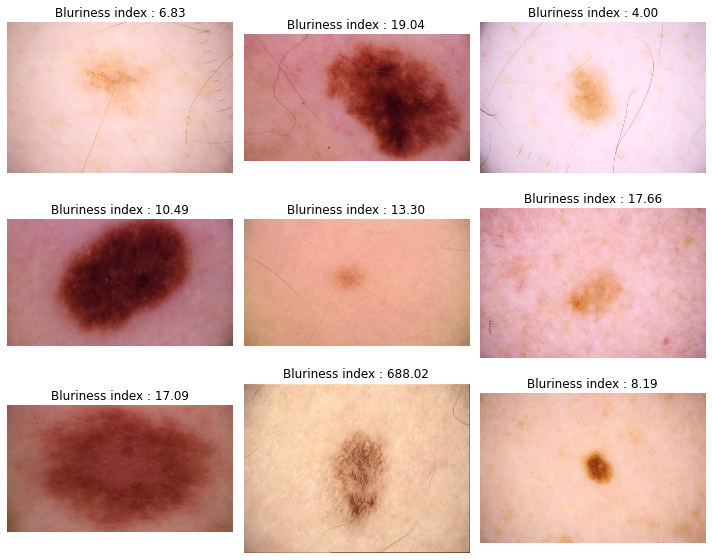

In [8]:
show9(random9_ben, 'benign')

And now lets look at 9 random malignant leisions images and estimate their bluriness

Display malignant Images


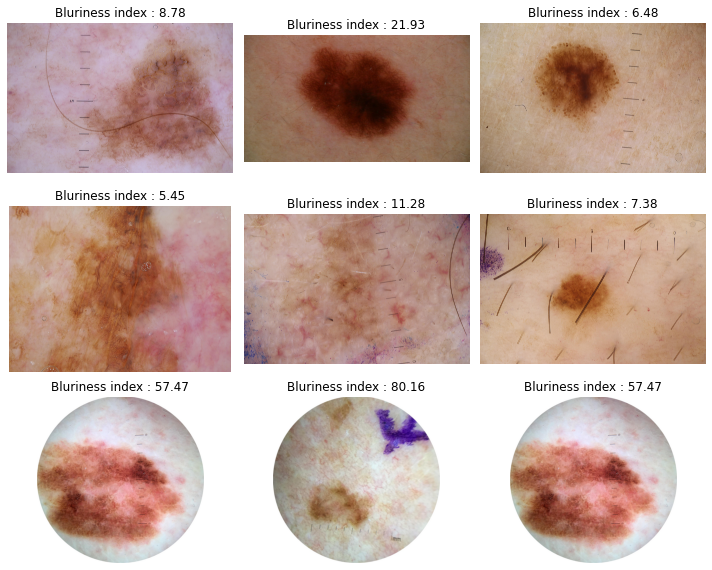

In [9]:
show9(random9_mal, 'malignant')

In [86]:
def show9_RGB(images, l_type):
    print(f'Display {l_type} Images')
    N_subplots = 6
    color = ('b','g','r')

    # Iterate and plot random images
    for i in range(9):
        fig = plt.figure()
        fig.set_figwidth(20)
        fig.set_figheight(3)
        img = plt.imread(os.path.join(img_dir, images[i]))
        ax = fig.add_subplot(1, N_subplots, 1)
        imgplot = plt.imshow(img)
        ax.set_title(f'Size: {img.shape}')
        plt.axis('off')

        for i,col in enumerate(color):
            ax = fig.add_subplot(1, N_subplots, i+2)
            imgplot = plt.imshow(img[:,:,i], cmap='gray')
            ax.set_title(col)
            plt.axis('off')

        color = ('b','g','r')
        ax = fig.add_subplot(1, N_subplots, 5)
        for i,col in enumerate(color):
            histr = cv2.calcHist([img],[i],None,[256],[0,255]) #excluding pure white 255 pixels of the borders in the images
            plt.plot(histr,color = col)
            plt.xlim([0,256])

        ax = fig.add_subplot(1, N_subplots, 6)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mat, fm = laplacian(gray)
        ax.set_title(f'Bluriness index : {fm:.2f}')
        plt.hist(mat.ravel(), bins=100) 
        plt.show()

And now we'll analyze these images by separate channels and plot the histograms

Display Malignant Images


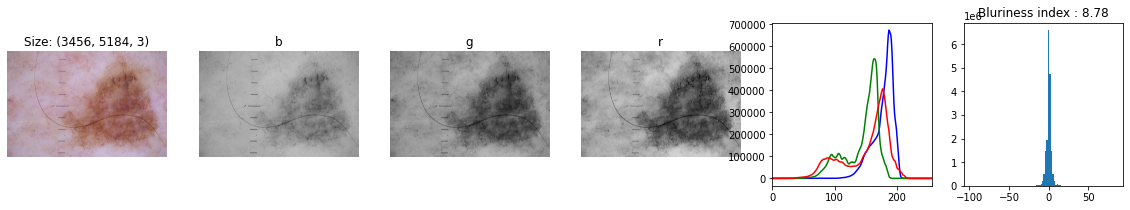

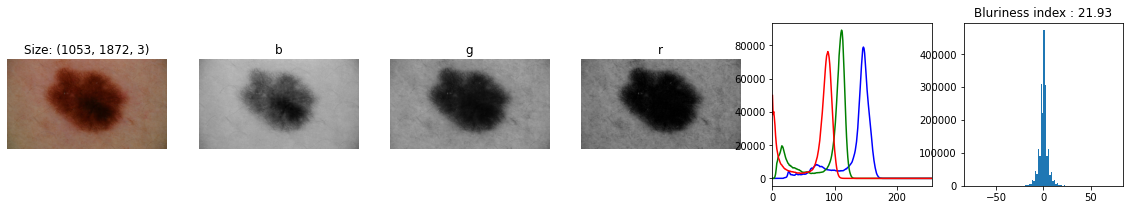

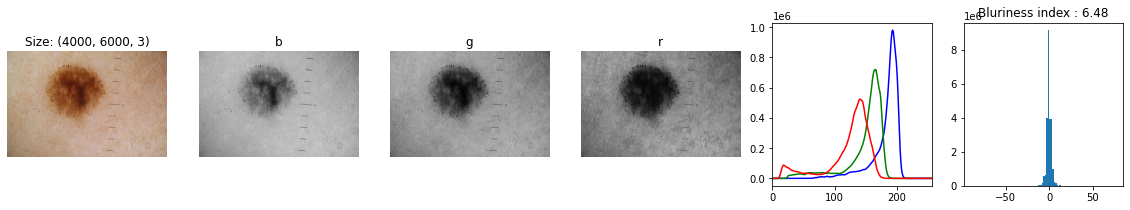

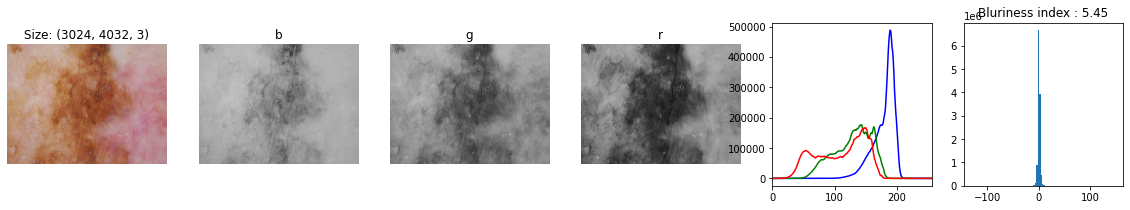

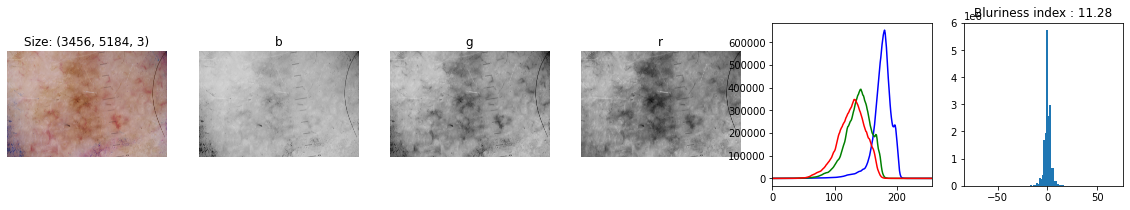

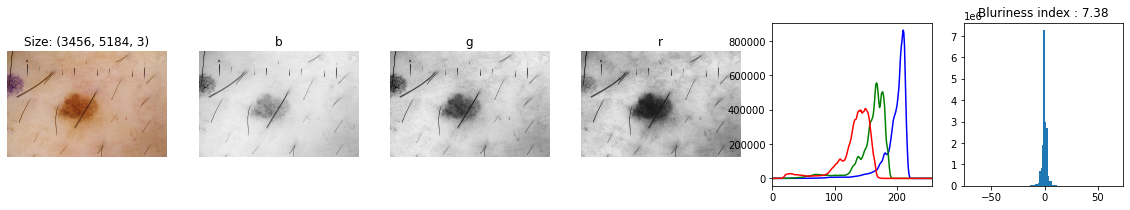

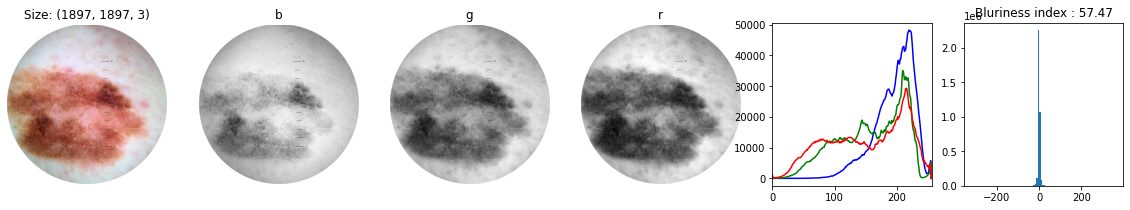

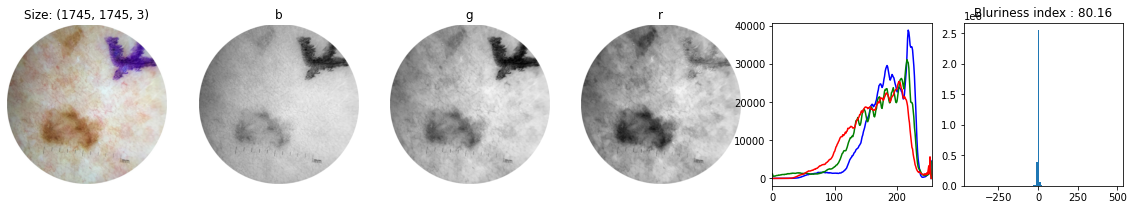

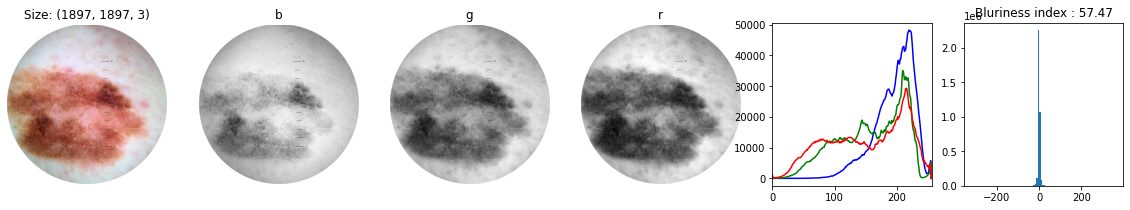

In [87]:
show9_RGB(random9_mal, 'Malignant')

Display Benign Images


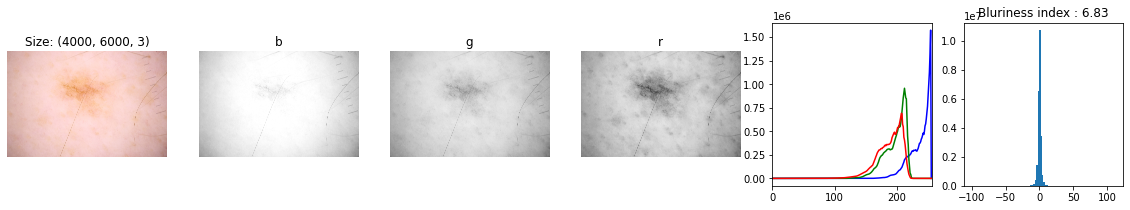

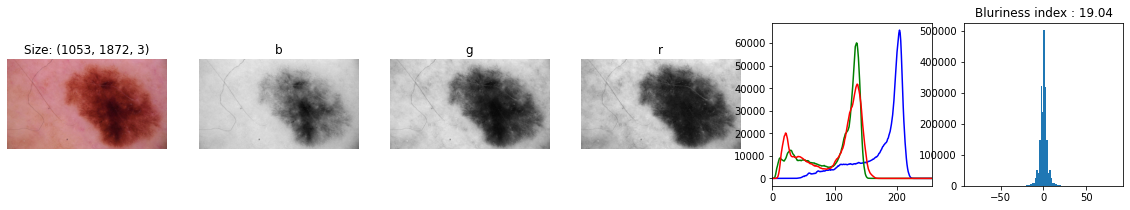

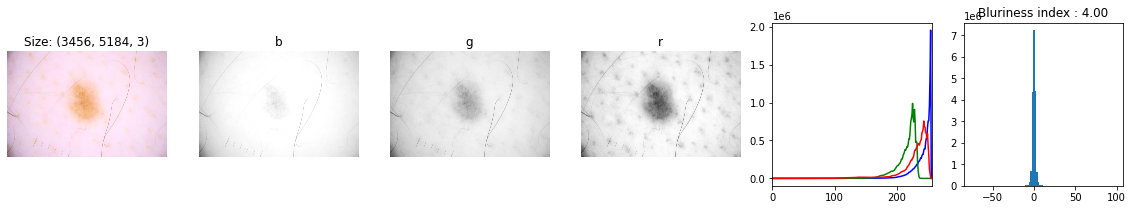

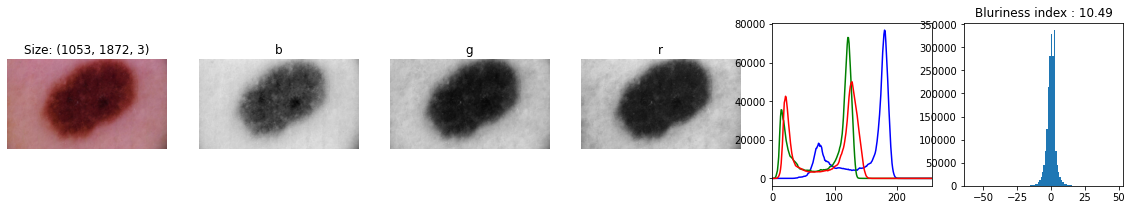

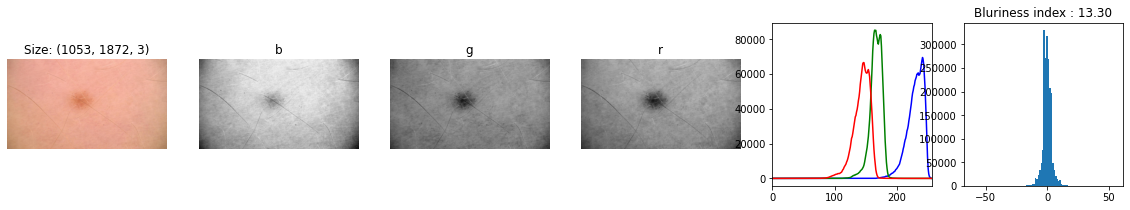

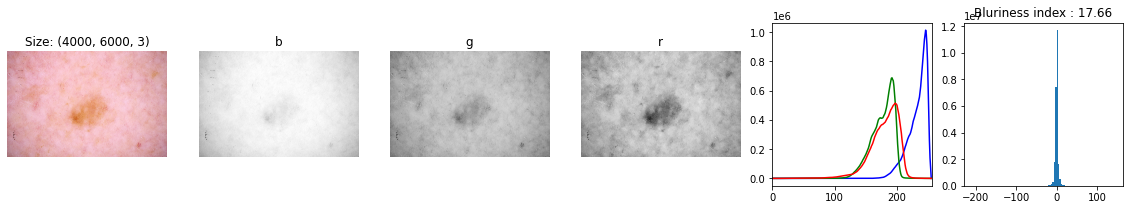

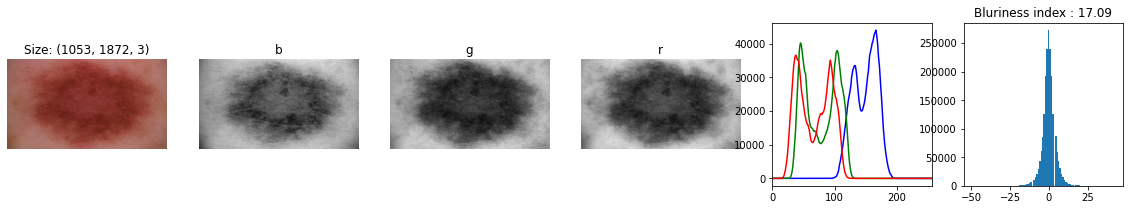

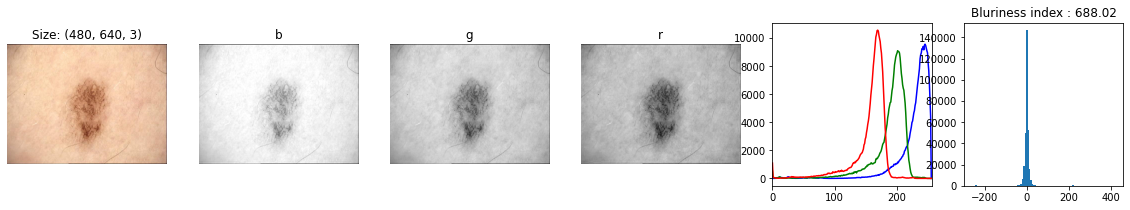

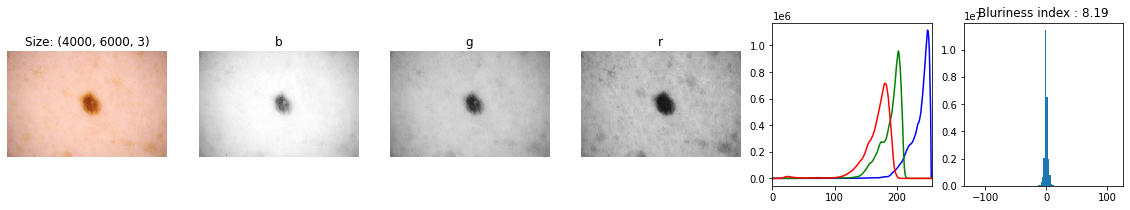

In [88]:
show9_RGB(random9_ben, 'Benign')

In [90]:
# N_subplots = 6
# img = cv2.imread(os.path.join(img_dir, random9_mal[8]))
# color = ('b','g','r')
# fig = plt.figure()
# fig.set_figwidth(20)
# fig.set_figheight(3)

# ax = fig.add_subplot(1, N_subplots, 1)
# imgplot = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# ax.set_title(f'Size: {img.shape}')
# plt.axis('off')

# for i,col in enumerate(color):
#     ax = fig.add_subplot(1, N_subplots, i+2)
#     imgplot = plt.imshow(img[:,:,i], cmap='gray')
#     ax.set_title(col)
#     plt.axis('off')
# # plt.show()

# color = ('b','g','r')
# ax = fig.add_subplot(1, N_subplots, 5)
# for i,col in enumerate(color):
#     histr = cv2.calcHist([img],[i],None,[256],[0,255])
# #     histr = cv2.calcHist([img],[i],None,[256],[0,256])
#     plt.plot(histr,color = col)
#     plt.xlim([0,256])
# # plt.show()

# ax = fig.add_subplot(1, N_subplots, 6)
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# mat, fm = laplacian(gray)
# ax.set_title(f'Bluriness index : {fm:.2f}')
# plt.hist(mat.ravel(), bins=100) 
# plt.show()

# img_ben = cv2.imread(os.path.join(img_dir, random9_ben[7]))
# gray_ben = cv2.cvtColor(img_ben, cv2.COLOR_BGR2GRAY)
# mat, fm = laplacian(gray_ben)
# print(f'Bluriness index : {fm:.2f}')
# print(mat.shape, img_ben.shape)
# plt.hist(mat.ravel(), bins=100) #calculating histogram
# plt.show()

It seems we'll have a really difficult challenge to decide if an image is blurry using this approach with laplacian operator.

In [93]:
blur_idxs = []
for i in range(train_df.shape[0]):
    img_ben = cv2.imread(os.path.join(img_dir, train_df.iloc[i].image_name+'.jpg'))
    gray_ben = cv2.cvtColor(img_ben, cv2.COLOR_BGR2GRAY)
    fm = variance_of_laplacian(gray_ben)
    blur_idxs.append(fm)
print(len(blur_idxs))    

33126


Lets see this blur index distribution over all images in the train dataset.

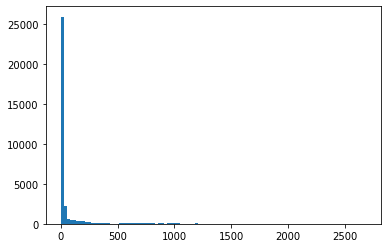

In [94]:
plt.hist(blur_idxs, bins=100) #calculating histogram
plt.show()

As I suspected the absolute majority of the images has index below 25, which would implicate very blurry image if it was a regular photograph.